# CS4248 Project - Labelled Unreliable News (LUN)

## Imports

In [1]:
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from textblob import TextBlob
from readability import Readability

import warnings
warnings.filterwarnings('ignore')

In [2]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

stop_words = set(stopwords.words('english'))
TEST_SIZE = 0.1

## Load Data

In [4]:
full_train_df = pd.read_csv('raw_data/fulltrain.csv', header=None)
full_train_df.columns = ['label', 'text']
full_train_df.head()

,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [5]:
train_df = full_train_df.drop_duplicates(subset=['text'])
print(f"No. training samples (all classes): {len(train_df)}")

No. training samples (all classes): 48652


In [6]:
train_df = train_df.sample(10000)
print(f"No. training samples (all classes): {len(train_df)}")

No. training samples (all classes): 10000


## Feature Engineering

In [7]:
def contraction_count(text):
    count = 0
    for contract in contractions:
        count += re.subn(contract, '', text)[1]
    return count

def count_stopwords(text):  
    stopwords = nltk.corpus.stopwords.words("english")
    word_tokens = word_tokenize(text)
    stopwords_list = [w for w in word_tokens if w in stopwords]
    return len(stopwords_list)

def count_special_characters(text):
    count = 0
    for i in range(len(text)):
        if(not text[i].isalpha() and not text[i].isdigit()):
            count += 1
    return count

def count_uppercase(text):
    count = 0
    for i in range(len(text)):
        if(text[i].isupper()):
            count += 1
    return count

def count_lowercase(text):
    count = 0
    for i in range(len(text)):
        if(text[i].islower()):
            count += 1
    return count

def count_noun_verb_adverb_adjective(text):
    word_tokens = word_tokenize(text)
    word_tagged = pos_tag(word_tokens, tagset='universal')
    noun_count = 0
    verb_count = 0
    adv_count = 0
    adj_count = 0
    for pair in word_tagged:
        tag = pair[1]
        if tag == 'NOUN':
            noun_count += 1
        elif tag == 'VERB':
            verb_count += 1
        elif tag == 'ADV':
            adv_count += 1
        elif tag == 'ADJ':
            adj_count += 1
    return (noun_count, verb_count, adv_count, adj_count)

def count_syllable(text):
    words = word_tokenize(text)
    count = 0
    vowels = "aeiouy"
    for word in words:
        count += count_syllable_in_word(word, vowels)
    return count

def count_syllable_in_word(word, vowels):
    count = 0
    word = word.lower()
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

def count_article(text):
    count = 0
    words = text.split(" ")
    for word in words:
        word = word.lower()
        if word == "a" or word == "an" or word == "the":
            count += 1
    return count

def get_gunning_fog_grade_index(text):
    # 0.4 [(words/sentences) + 100 (complex words/words)]
    # Complex words are those containing three or more syllables.
    sents = sent_tokenize(text)
    words = word_tokenize(text)
    num_sents = len(sents)
    num_words = len(words)
    num_complex_words = 0
    for word in words:
        if count_syllable_in_word(word, "aeiouy") >= 3:
            num_complex_words += 1
    return 0.4*(num_words/num_sents) + 100*(num_complex_words/num_words)
    
def get_dale_chall_readability_coleman_liau_index(text):
    try:
        r = Readability(text)
        return (r.dale_chall().score, r.coleman_liau().score)
    except:
        return (0, 0)

In [8]:
# Complexity Features
train_df['num_stopwords'] = train_df['text'].apply(lambda x: count_stopwords(x))
train_df['num_sentences'] = train_df['text'].apply(lambda x: len(str(x).split('.')))
train_df['num_contractions'] = train_df['text'].apply(lambda x: contraction_count(x))
train_df['num_special_characters'] = train_df['text'].apply(lambda x: count_special_characters(x))
train_df['num_uppercase'] = train_df['text'].apply(lambda x: count_uppercase(x))
train_df['num_lowercase'] = train_df['text'].apply(lambda x: count_lowercase(x))

In [9]:
# Stylometric Features
train_df['pos_tags'] = train_df['text'].apply(lambda x: count_noun_verb_adverb_adjective(x))
train_df['num_noun'] = train_df['pos_tags'].apply(lambda x: x[0])
train_df['num_verb'] = train_df['pos_tags'].apply(lambda x: x[1])
train_df['num_adverb'] = train_df['pos_tags'].apply(lambda x: x[2])
train_df['num_adjective'] = train_df['pos_tags'].apply(lambda x: x[3])
train_df['num_syllables'] = train_df['text'].apply(lambda x: count_syllable(x))
train_df['num_article'] = train_df['text'].apply(lambda x: count_article(x))

In [10]:
# Readability based evidence
train_df['gunning_fog_grade_index'] = train_df['text'].apply(lambda x: get_gunning_fog_grade_index(x))
train_df['readability_indices'] = train_df['text'].apply(lambda x: get_dale_chall_readability_coleman_liau_index(x))
train_df['dale_chall_readability'] = train_df['readability_indices'].apply(lambda x: x[0])
train_df['coleman_liau_index'] = train_df['readability_indices'].apply(lambda x: x[1])

In [11]:
# Psycho-linguistic features
train_df['psycho-linguistic'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment)
train_df['polarity'] = train_df['psycho-linguistic'].apply(lambda x: x[0])
train_df['subjectivity'] = train_df['psycho-linguistic'].apply(lambda x: x[1])

In [12]:
features = ['num_stopwords', 'num_sentences', 'num_contractions', 'num_special_characters', 'num_uppercase', 'num_lowercase',
            'num_noun', 'num_verb', 'num_adverb', 'num_adjective', 'num_syllables', 'num_article',
            'gunning_fog_grade_index', 'dale_chall_readability', 'coleman_liau_index',
            'polarity', 'subjectivity', ]

In [13]:
X = train_df[features]
y = train_df['label'].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=42)

## Logistic Regression with Custom Features

In [15]:
logreg = LogisticRegression(random_state=42, solver='newton-cg').fit(X_train, y_train)
y_pred = logreg.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy: 0.7927777777777778
F1 score: 0.7781396913595051


In [16]:
param_grid_ = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
logreg_search = GridSearchCV(LogisticRegression(random_state=42, solver='newton-cg'), param_grid=param_grid_)
logreg_search.fit(X_train, y_train)
print("Searched best score is:", logreg_search.best_score_)
print("Searched best Regularization strength is:", logreg_search.best_params_)

Searched best score is: 0.7922222222222223
Searched best Regularization strength is: {'C': 10}


In [17]:
search_results = pd.DataFrame.from_dict({'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                                         'logreg': logreg_search.cv_results_['mean_test_score']})
search_results

,C,logreg
0,0.0001,0.765333
1,0.0010,0.775889
2,0.0100,0.788000
3,0.1000,0.791222
4,1.0000,0.792000
5,10.0000,0.792222


### Rebuild Model with Best C

In [18]:
logreg = LogisticRegression(solver='newton-cg', C=logreg_search.best_params_['C']).fit(X_train, y_train)
y_pred = logreg.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy: 0.7942222222222223
F1 score: 0.7798131650724183


### Testing

In [19]:
y_pred = logreg.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

Accuracy: 0.772
F1 score: 0.7603836579629233


### Validation

In [20]:
test_df = pd.read_csv('raw_data/balancedtest.csv', header=None, names=['label', 'text'])
print(f"No. test samples (all classes): {len(test_df)}")
test_df.sample(5)

No. test samples (all classes): 3000


,label,text
1492,2,New Obama Move: Less Military Surplus Equipmen...
1140,2,Obama Dances His Last Tango With Communism Whi...
1091,2,Wheres The Beef? Youre Not Going To Believe Th...
2008,3,Tweet The Food and Drug Administration (FDA) ...
1108,2,Combat Patches Removed For INSANE Reason- Sold...


In [21]:
# Complexity Features
test_df['num_stopwords'] = test_df['text'].apply(lambda x: count_stopwords(x))
test_df['num_sentences'] = test_df['text'].apply(lambda x: len(str(x).split('.')))
test_df['num_contractions'] = test_df['text'].apply(lambda x: contraction_count(x))
test_df['num_special_characters'] = test_df['text'].apply(lambda x: count_special_characters(x))
test_df['num_uppercase'] = test_df['text'].apply(lambda x: count_uppercase(x))
test_df['num_lowercase'] = test_df['text'].apply(lambda x: count_lowercase(x))

In [22]:
# Stylometric Features
test_df['pos_tags'] = test_df['text'].apply(lambda x: count_noun_verb_adverb_adjective(x))
test_df['num_noun'] = test_df['pos_tags'].apply(lambda x: x[0])
test_df['num_verb'] = test_df['pos_tags'].apply(lambda x: x[1])
test_df['num_adverb'] = test_df['pos_tags'].apply(lambda x: x[2])
test_df['num_adjective'] = test_df['pos_tags'].apply(lambda x: x[3])
test_df['num_syllables'] = test_df['text'].apply(lambda x: count_syllable(x))
test_df['num_article'] = test_df['text'].apply(lambda x: count_article(x))

In [23]:
# Readability based evidence
test_df['gunning_fog_grade_index'] = test_df['text'].apply(lambda x: get_gunning_fog_grade_index(x))
test_df['readability_indices'] = test_df['text'].apply(lambda x: get_dale_chall_readability_coleman_liau_index(x))
test_df['dale_chall_readability'] = test_df['readability_indices'].apply(lambda x: x[0])
test_df['coleman_liau_index'] = test_df['readability_indices'].apply(lambda x: x[1])

In [24]:
# Psycho-linguistic features
test_df['psycho-linguistic'] = test_df['text'].apply(lambda x: TextBlob(x).sentiment)
test_df['polarity'] = test_df['psycho-linguistic'].apply(lambda x: x[0])
test_df['subjectivity'] = test_df['psycho-linguistic'].apply(lambda x: x[1])

In [25]:
X_val = test_df[features]
y_val = test_df['label'].values

In [26]:
y_pred_val = logreg.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.37766666666666665
F1 score: 0.36532706824510625


In [27]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.40      0.38      0.39       750
        hoax       0.37      0.28      0.32       750
  propaganda       0.15      0.15      0.15       750
    reliable       0.53      0.71      0.60       750

    accuracy                           0.38      3000
   macro avg       0.36      0.38      0.37      3000
weighted avg       0.36      0.38      0.37      3000



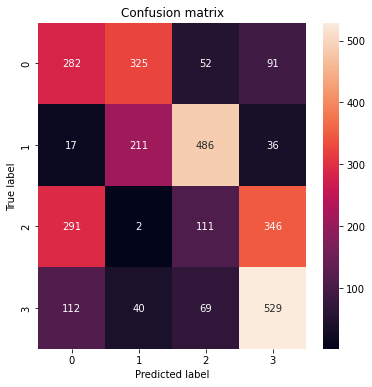

In [28]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	

In [36]:
importance = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(logreg.coef_[0], 3)})
importance = importance.sort_values('Importance',ascending=False)
importance.head(10)

,Feature,Importance
2,num_contractions,3.905
16,subjectivity,2.462
15,polarity,0.403
13,dale_chall_readability,0.215
3,num_special_characters,0.077
8,num_adverb,0.034
12,gunning_fog_grade_index,0.029
5,num_lowercase,0.007
11,num_article,-0.006
9,num_adjective,-0.017
